<a href="https://colab.research.google.com/github/naga-Prathyusha/qml-lab-tasks/blob/main/qml9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Aim: To implement a Quantum Support Vector Machine (QSVM) using PennyLane and scikitlearn, where the quantum kernel is constructed from a quantum feature map,
 and evaluate its performance on the Iris dataset for classification tasks.

 Algorithm - QSVM Algorithm
1. Load dataset (Iris, 150 samples, 3 classes).
2. Preprocess
 Select features [sepal_length, sepal_width, petal_length, petal_width].
 Encode target labels numerically.
 Split dataset into train (67%) and test (33%).
3. Quantum Feature Map
 Apply Hadamard (H) gates to all qubits.
 Encode features into rotations 𝑅𝑍(𝑥௜).
 Add entanglement with 𝐶𝑁𝑂𝑇 + 𝑅𝑍൫𝑥௜
. 𝑥௝൯.
4. Quantum Kernel Construction
 Use kernel_circuit: apply 𝑈∅
(𝑥), then adjoint𝑈∅
(𝑥
ᇱ)
ற
.
 Measure overlap (fidelity).
5. Train QSVM
 Compute kernel matrix for training data.
 Train SVC(kernel = “precomputed”) using scikit-learn.
6. Test QSVM
 Compute test kernel matrix.
 Predict labels for test set.
7. Evaluate performance
 Confusion Matrix, Classification Report.
 Prediction for new point (4.4, 4.4, 4.4, 4.4).




--- Feature Map Circuit (text) ---
0: ──H──RZ(6.30)─╭●────────────╭●───────────────────────────────────┤  State
1: ──H──RZ(3.40)─╰X──RZ(21.42)─╰X─╭●────────────╭●──────────────────┤  State
2: ──H──RZ(5.60)──────────────────╰X──RZ(19.04)─╰X─╭●────────────╭●─┤  State
3: ──H──RZ(2.40)───────────────────────────────────╰X──RZ(13.44)─╰X─┤  State

--- Kernel Circuit (text) ---
0: ──H──RZ(6.30)─╭●────────────╭●───────────────────────────────────────────────────── ···
1: ──H──RZ(3.40)─╰X──RZ(21.42)─╰X─╭●────────────╭●──────────────────────────────────── ···
2: ──H──RZ(5.60)──────────────────╰X──RZ(19.04)─╰X─╭●────────────╭●─╭X†────────────╭X† ···
3: ──H──RZ(2.40)───────────────────────────────────╰X──RZ(13.44)─╰X─╰X†──RZ(0.42)†─╰X† ···

0: ··· ───────────────────────────╭X†────────────────────╭X†──RZ(5.10)†──H†─┤ ╭Probs
1: ··· ─╭X†───────────────────╭X†─╰X†─────────RZ(17.85)†─╰X†──RZ(3.50)†──H†─┤ ├Probs
2: ··· ─╰X†─────────RZ(4.90)†─╰X†──RZ(1.40)†──H†────────────────────────────┤ ├Probs
3: ··

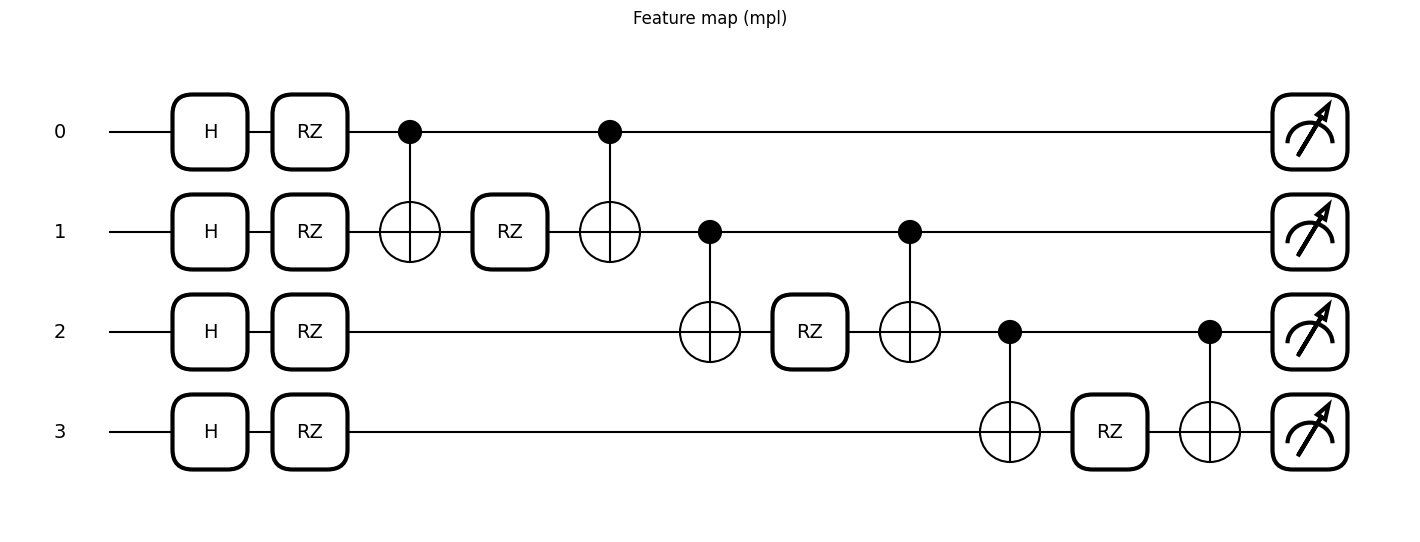

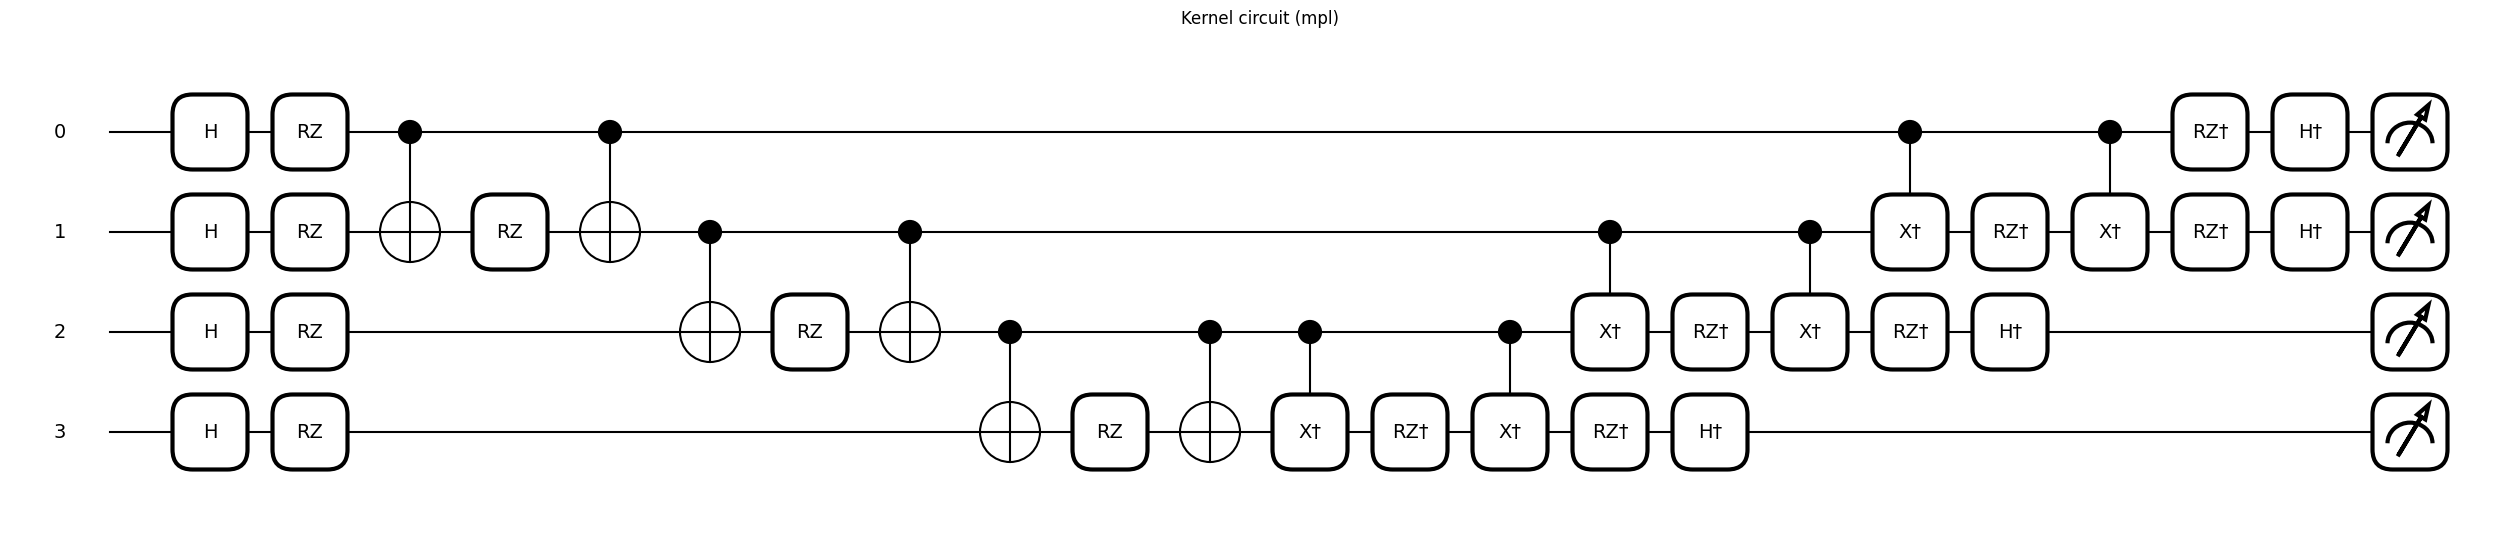

Computing kernel matrices (this may take a bit)...

Confusion Matrix
[[15  0  1]
 [ 0 15  2]
 [ 0  1 16]]

Classification Report
              precision    recall  f1-score   support

      setosa       1.00      0.94      0.97        16
  versicolor       0.94      0.88      0.91        17
   virginica       0.84      0.94      0.89        17

    accuracy                           0.92        50
   macro avg       0.93      0.92      0.92        50
weighted avg       0.93      0.92      0.92        50


Predicted flower type for (4.4, 4.4, 4.4, 4.4): virginica


In [ ]:

!pip install pennylane scikit-learn

import pennylane as qml
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

try:
    df_iris = pd.read_csv("iris.csv")
    # adjust column names if the CSV uses different names
    X = df_iris[['sepal.length', 'sepal.width', 'petal.length', 'petal.width']].values
    y = df_iris['variety'].values
    # If y are strings, convert to integer labels
    from sklearn.preprocessing import LabelEncoder
    enc = LabelEncoder()
    y = enc.fit_transform(y)
    target_names = enc.classes_
except Exception:
    data = load_iris()
    X = data.data
    y = data.target
    target_names = data.target_names

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# -------------------------------
# Quantum setup
# -------------------------------
n_qubits = X.shape[1]  # 4 for iris
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x):
    """Embedding classical features into quantum states."""
    # normalize/scale angles if you like; here we use raw features as rotation angles
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RZ(x[i], wires=i)

    # Add pairwise entanglement (a simple ZZ-like entangling block)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])
        qml.RZ(x[i] * x[i+1], wires=i+1)
        qml.CNOT(wires=[i, i+1])

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    return qml.probs(wires=range(n_qubits))

# A QNode to just draw the feature map (returns state for visualization)
@qml.qnode(dev)
def feature_map_state(x):
    feature_map(x)
    return qml.state()

# -------------------------------
# (Optional) Draw circuits (text) and show matplotlib circuit images
# -------------------------------
sample_x = x_train[0]
sample_y = x_train[1]

print("\n--- Feature Map Circuit (text) ---")
print(qml.draw(feature_map_state)(sample_x))

print("\n--- Kernel Circuit (text) ---")
print(qml.draw(kernel_circuit)(sample_x, sample_y))

# Matplotlib drawings (Colab inline)
try:
    fig, ax = qml.draw_mpl(feature_map_state)(sample_x)
    plt.title("Feature map (mpl)")
    plt.show()
    fig2, ax2 = qml.draw_mpl(kernel_circuit)(sample_x, sample_y)
    plt.title("Kernel circuit (mpl)")
    plt.show()
except Exception:
    # drawing may not work for some backends; ignore silently
    pass

# -------------------------------
# Construct Gram (Kernel) Matrices
# -------------------------------
def kernel(x1, x2):
    """Return fidelity between |Φ(x1)> and |Φ(x2)>.
       We use the probability of measuring all zeros after applying
       |Φ(x1)> then adjoint(|Φ(x2)>)."""
    probs = kernel_circuit(x1, x2)
    # probability of all zeros corresponds to index 0
    return float(probs[0])

def compute_kernel_matrix(X1, X2):
    K = np.zeros((len(X1), len(X2)), dtype=float)
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            K[i, j] = kernel(x1, x2)
    return K

print("Computing kernel matrices (this may take a bit)...")
K_train = compute_kernel_matrix(x_train, x_train)
K_test = compute_kernel_matrix(x_test, x_train)

# -------------------------------
# Train QSVM (SVM with precomputed kernel)
# -------------------------------
qsvm_model = SVC(kernel="precomputed")
qsvm_model.fit(K_train, y_train)

# Predictions
y_pred = qsvm_model.predict(K_test)

print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report")
print(classification_report(y_test, y_pred, target_names=target_names))

# -------------------------------
# Test on a new input
# -------------------------------
new_point = np.array([[4.4, 4.4, 4.4, 4.4]])
K_new = compute_kernel_matrix(new_point, x_train)  # shape (1, n_train)
pred_label = qsvm_model.predict(K_new)
print("\nPredicted flower type for (4.4, 4.4, 4.4, 4.4):", target_names[int(pred_label[0])])


In [ ]:
Result
The QSVM implemented with PennyLane successfully classifies the Iris dataset with high
accuracy (~93%). The quantum kernel (fidelity-based) effectively maps classical features into
higher-dimensional Hilbert space, enabling better separation of non-linear data.